In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daataset/my_data (1).csv
/kaggle/input/daataset/P09-imu-left.csv


In [17]:
df=pd.read_csv('/kaggle/input/daataset/my_data (1).csv')

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import classification_report
RANDOM_SEED = 42
%matplotlib inline

In [19]:
activities_to_remove = ['HeadShakingRightWhileRunning','HeadShakingLeftWhileRunning','HeadNodUpWhileRunning','INIT1WhileINITI','HeadYawLeftWhileRunning','HeadNodDownWhileRunning','HeadYawRightWhileRunning','INIT2WhileWalking','INIT2WhileRunning','INIT2WhileStaying','INIT1WhileINIT1']
df = df[~df['Activity'].isin(activities_to_remove)]


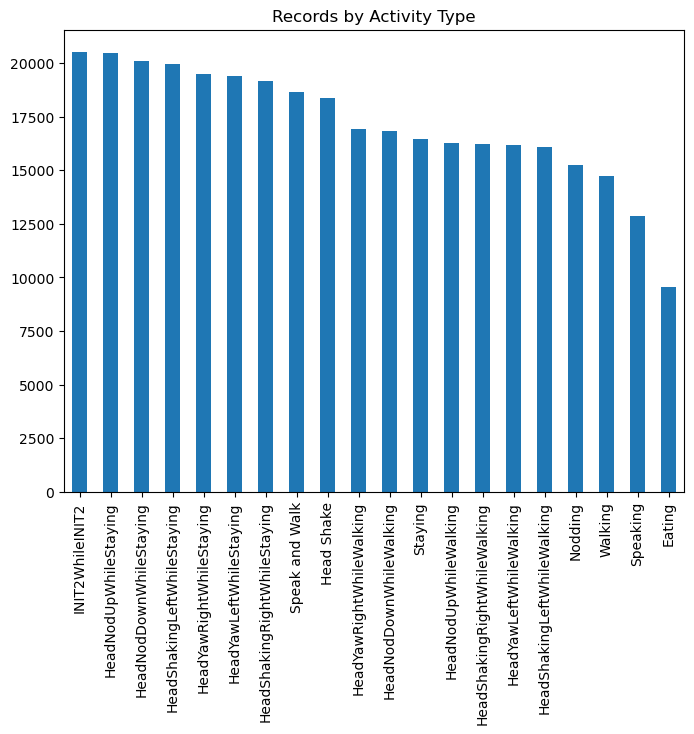

In [20]:
df['Activity'].value_counts().plot(kind='bar', title='Records by Activity Type', figsize=(8, 6),align='center');

In [21]:
df['Ax'] = df['Ax'] / df['Ax'].max()
df['Ay'] = df['Ay'] / df['Ay'].max()
df['Az'] = df['Az'] / df['Az'].max()

df['Gx'] = df['Gx'] / df['Gx'].max()
df['Gy'] = df['Gy'] / df['Gy'].max()
df['Gz'] = df['Gz'] / df['Gz'].max()

# Round numbers
df = df.round({'Ax': 5, 'Ay': 5, 'Az': 5, 'Gx': 5, 'Gy': 5, 'Gz': 5})
N_TIME_STEPS = 20
N_FEATURES = 6
step = 1
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    Ax = df['Ax'].values[i: i + N_TIME_STEPS]
    Ay = df['Ay'].values[i: i + N_TIME_STEPS]
    Az = df['Az'].values[i: i + N_TIME_STEPS]
    
    Gx = df['Gx'].values[i: i + N_TIME_STEPS]
    Gy = df['Gy'].values[i: i + N_TIME_STEPS]
    Gz = df['Gz'].values[i: i + N_TIME_STEPS]
    
    label = stats.mode(df['Activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([Ax, Ay, Az, Gx, Gy, Gz])
    labels.append(label)

/tmp/ipykernel_32/206695776.py:25: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['Activity'][i: i + N_TIME_STEPS])[0][0]
/tmp/ipykernel_32/206695776.py:25: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  label = stats.mode(df['Activity'][i: i + N_TIME_STEPS])[0][0]


In [22]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [23]:
print('reshaped_segments : ', reshaped_segments.shape)
print('labels : ', labels.shape)

reshaped_segments :  (343467, 20, 6)
labels :  (343467, 20)


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.3)

In [25]:
X_trrain, X_teest, y_trrain, y_teest = train_test_split(X_train, y_train, test_size=0.2)

In [26]:
verbose = 1
epochs = 70
batch_size = 100

n_timesteps = X_trrain.shape[1]
n_features = X_trrain.shape[2]
n_outputs = y_trrain.shape[1]

print('n_timesteps : ', n_timesteps)
print('n_features : ', n_features)
print('n_outputs : ', n_outputs)

n_timesteps :  20
n_features :  6
n_outputs :  20


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization

# Define the LSTM model
model = Sequential()
model.add(BatchNormalization(input_shape=(n_timesteps,n_features))) 
model.add(LSTM(100, activation='relu', return_sequences=False))  
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
# fit network
history = model.fit(X_trrain, y_trrain, validation_data=(X_teest, y_teest), 
                    epochs=40, batch_size=batch_size, verbose=verbose)

Epoch 1/40
1924/1924 [==============================] - 66s 33ms/step - loss: 1.8113 - accuracy: 0.3781 - val_loss: 1.3083 - val_accuracy: 0.5176
Epoch 2/40
1924/1924 [==============================] - 65s 34ms/step - loss: 1.1693 - accuracy: 0.5663 - val_loss: 1.0533 - val_accuracy: 0.6144
Epoch 3/40
1924/1924 [==============================] - 68s 36ms/step - loss: 0.9822 - accuracy: 0.6350 - val_loss: 0.9221 - val_accuracy: 0.6590
Epoch 4/40
1924/1924 [==============================] - 64s 33ms/step - loss: 0.8683 - accuracy: 0.6786 - val_loss: 0.8249 - val_accuracy: 0.6982
Epoch 5/40
1924/1924 [==============================] - 64s 33ms/step - loss: 0.7844 - accuracy: 0.7105 - val_loss: 0.7317 - val_accuracy: 0.7285
Epoch 6/40
1924/1924 [==============================] - 69s 36ms/step - loss: 0.7290 - accuracy: 0.7302 - val_loss: 0.7156 - val_accuracy: 0.7369
Epoch 7/40
1924/1924 [==============================] - 64s 33ms/step - loss: 0.6847 - accuracy: 0.7471 - val_loss: 0.6546 -

3221/3221 [==============================] - 19s 6ms/step


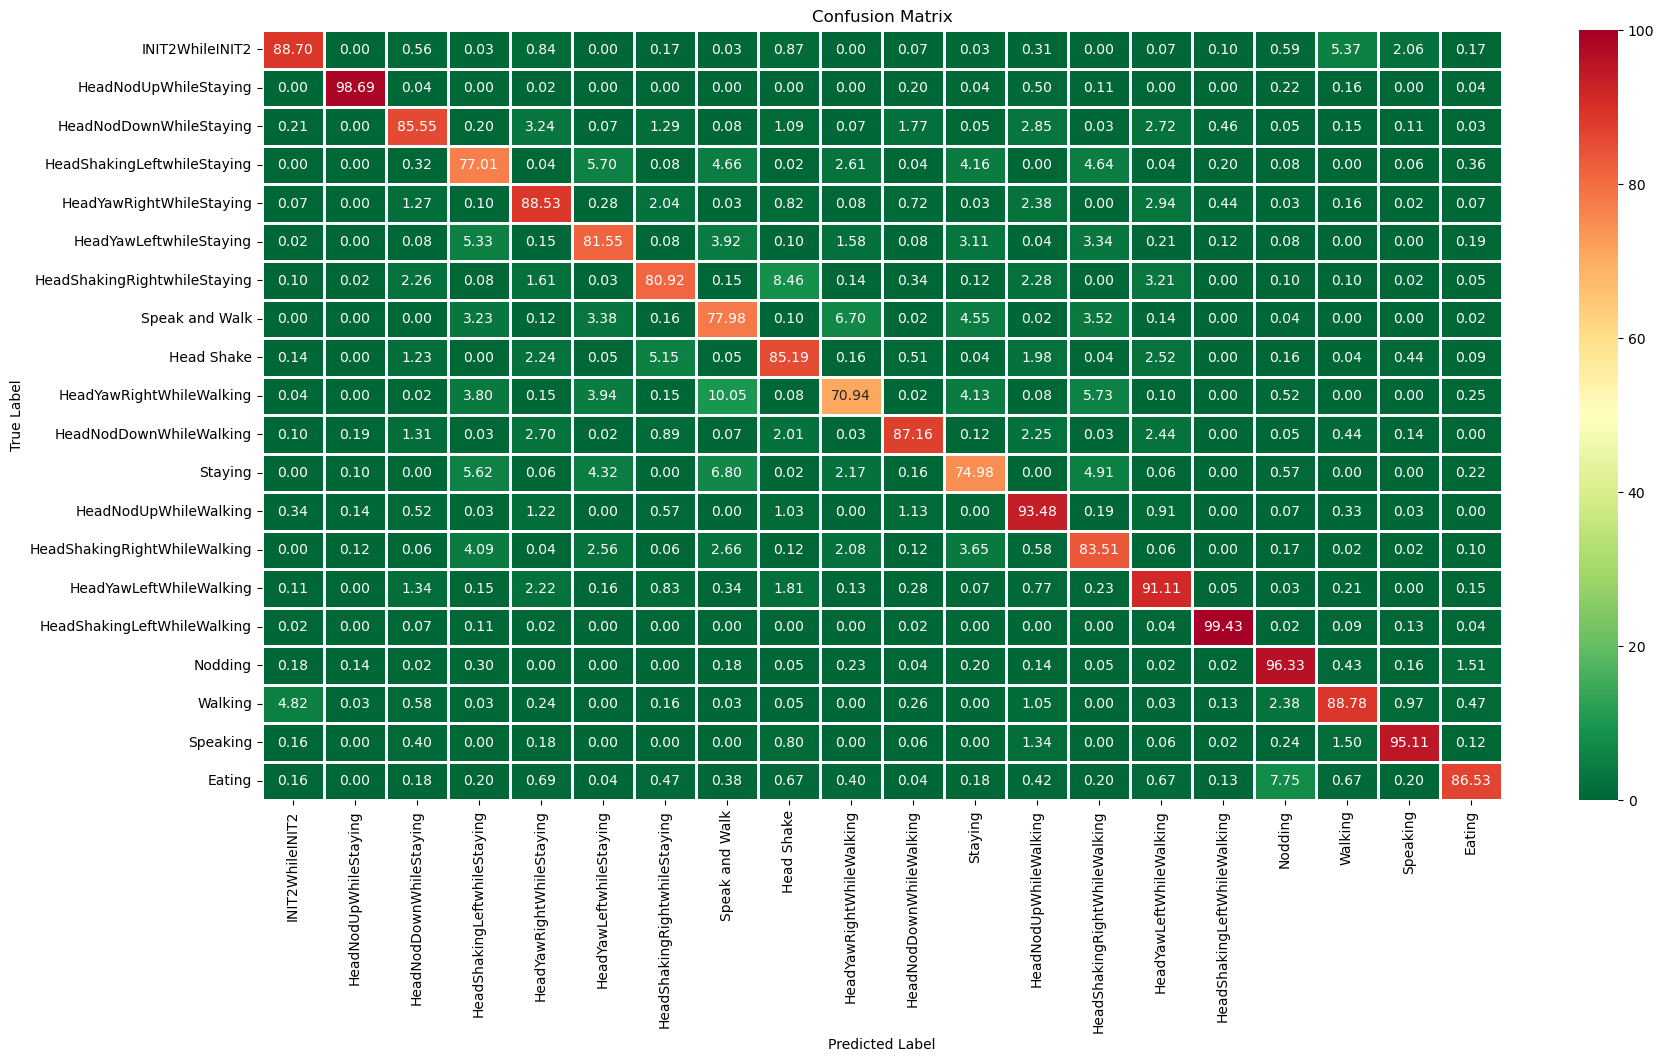

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2866
           1       0.99      0.99      0.99      5570
           2       0.90      0.86      0.88      6144
           3       0.77      0.77      0.77      5067
           4       0.86      0.89      0.87      6129
           5       0.79      0.82      0.80      4818
           6       0.87      0.81      0.84      5886
           7       0.72      0.78      0.75      4854
           8       0.83      0.85      0.84      5714
           9       0.81      0.71      0.76      4818
          10       0.94      0.87      0.90      5731
          11       0.78      0.75      0.77      4929
          12       0.85      0.93      0.89      5816
          13       0.79      0.84      0.81      5155
          14       0.86      0.91      0.88      6116
          15       0.98      0.99      0.99      4533
          16       0.90      0.96      0.93      5617
          17       0.90    

In [29]:

# confusion matrix
LABELS = ['INIT2WhileINIT2','HeadNodUpWhileStaying','HeadNodDownWhileStaying','HeadShakingLeftwhileStaying','HeadYawRightWhileStaying','HeadYawLeftwhileStaying','HeadShakingRightwhileStaying','Speak and Walk','Head Shake','HeadYawRightWhileWalking','HeadNodDownWhileWalking','Staying','HeadNodUpWhileWalking','HeadShakingRightWhileWalking','HeadYawLeftWhileWalking','HeadShakingLeftWhileWalking','Nodding','Walking','Speaking','Eating']
y_pred_test = model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

matrix = metrics.confusion_matrix(max_y_test, max_y_pred_test)
matrix = (matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis])*100
fmt = '.2f'
plt.figure(figsize=(20, 10))
sns.heatmap(matrix,
            cmap='RdYlGn_r',
            linecolor='white',
            linewidths=1,
            xticklabels= LABELS,
            yticklabels= LABELS,
            annot=True,
            fmt=fmt,
           vmax = 100)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(max_y_test, max_y_pred_test))


In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy: ", accuracy_score(max_y_test, max_y_pred_test))

Accuracy:  0.8667617744393009
